# Bisimulation Metric


In [20]:
# Plot the heatmap of the distance matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distance_matrix(d, states, annot = False, heatmap_range = None):
    vmin, vmax = heatmap_range
    if annot:
        sns.heatmap(d, cmap='viridis', annot=True, fmt=".2f", xticklabels=states, yticklabels=states, vmin=vmin, vmax=vmax)
    else:
        sns.heatmap(d, cmap='viridis', xticklabels=states, yticklabels=states, vmin=vmin, vmax=vmax)
    plt.xlabel('States')
    plt.ylabel('States')
    plt.title('On-policy Bisimulation Metric')
    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from adjustText import adjust_text
from sklearn.cluster import KMeans


def plot_distances(d, states, n_clusters = 4):

    # Normalize the distance matrix
    d = d / np.max(d)

    # Apply Multidimensional Scaling (MDS)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    pos = mds.fit_transform(d)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pos)

    # Plot the result
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pos[:, 0], pos[:, 1], c=clusters, cmap='viridis', marker="o", s=50)

    # Annotate points with state numbers and adjust text to avoid overlap
    texts = []
    for i, (x, y) in enumerate(pos):
        texts.append(plt.text(x, y, str(states[i]), fontsize=11, ha='right'))

    adjust_text(texts)#, arrowprops=dict(arrowstyle='->', color='red'))

    # Create a legend
    handles, labels = scatter.legend_elements()
    legend_labels = [f'c{int(i)}' for i in range(len(labels))]
    plt.legend(handles, legend_labels, title="Clusters")

    plt.title('MDS Plot of States Based on Distances with Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grid_distance_heatmap(grid, valid_states, distances, state_evaluated = None, save_suffix = "", save = False, normalize = False):
    grid_shape = grid.shape[0]
    # Normalize the distance array (max - min normalization) as min is always 0
    if normalize:
        max_distance = np.max(distances)
        normalized_distances = distances / max_distance
    else:
        normalized_distances = distances

    # Create a grid with NaN values for invalid states
    heatmap = np.full(grid.shape, np.nan)

    # Fill the grid with the normalized distances
    for idx, (r, c) in enumerate(valid_states):
        heatmap[r, c] = normalized_distances[idx]

    # Plot the heatmap
    plt.figure(figsize=(5, 6))
    sns.heatmap(heatmap, annot=True, cmap='viridis', cbar=True, square=True, linewidths=0.5)
    plt.title(f'On-policy Bisimulation Metric, State: {state_evaluated}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(ticks=np.arange(grid_shape) + 0.5, labels=np.arange(grid_shape))
    plt.yticks(ticks=np.arange(grid_shape) + 0.5, labels=np.arange(grid_shape))

    # Save the plot
    if save:
        PATH_TO_SAVE = f'results/on_policy_bisimulation_metric{save_suffix}/'
        plt.savefig(PATH_TO_SAVE + f'on_policy_bisimulation_metric_{state_evaluated}{save_suffix}.png')

    plt.show()


In [4]:
import numpy as np
from collections import defaultdict

# We have 4 actions, corresponding to "down", "right", "up" and "left".
# Action 0: Down
# Action 1: Right
# Action 2: Up
# Action 3: Left
ACTION_SPACE = ['down', 'right', 'up', 'left']
POLICYACTION2ACTION = { 'u' : 'up',
                 'd' : 'down', 
                 'l' : 'left', 
                 'r' : 'right', 
                 'G' : 'right'} # Assume right from the goal

def get_next_state(r, c, action, grid):
    rows, cols = grid.shape

    if action == 'up':
        new_position = max(r - 1, 0), c
    elif action == 'down':
        new_position = min(r + 1, rows - 1), c
    elif action == 'left':
        new_position = r, max(c - 1, 0)
    elif action == 'right':
        new_position = r, min(c + 1, cols - 1)

    if grid[new_position]=="x" or grid[r][c]=="G":
        return r, c # don't move with a wall or when you are in the goal (it's practically a transition to the same state)
    else:
        return new_position


def get_net_state_walls(r, c, action, grid_shape):
    rows, cols = grid_shape

    if action == 'up':
        return max(r - 1, 0), c
    elif action == 'down':
        return min(r + 1, rows - 1), c
    elif action == 'left':
        return r, max(c - 1, 0)
    elif action == 'right':
        return r, min(c + 1, cols - 1)
    
def reward_function(state, action, grid):
    r, c = state

    grid_size = grid.shape[0]

    # NOTE: This environment is deterministic for that reason
    # and action only lead to one next possible state
    next_state = get_next_state(r, c, action, grid)

    # Define the reward if you are in the terminal state
    # And want to move (in theory but as it's a terminal state you don't move)
    if grid[state] == 'G':
        return 0
    
    # Define all the other rewards
    if grid[next_state] == 'G':
        return grid_size * 2
    # elif grid[next_state] == 'x' or state == next_state:
    #     return -1
    # else:
    #     return -1
    else:
        return -1
    
def transition_function(state, action, grid):
    r, c = state

    # NOTE: This environment is deterministic for that reason
    # and action only lead to one next possible state
    next_state = get_next_state(r, c, action, grid)

    # Define the transition if you are in the terminal state
    # if grid[state] == 'G':
    #     # return {next_state: 0.} # Terminal state not other possible transition
    #     return 1 # any action leads you to the same state
    
    # # Define all the other transitions
    # if grid[next_state] == 'x' or state == next_state:
    #     # return {state: 1.} # Transition to the same state
    #     return 0
    # else:
    #     # return {next_state: 1.} # Transition to the next state
    #     return 1   
    
    # NOTE: As I already defined that you should transition to the same state
    # There is always a transition with prob one

    # Only if you are in the terminal state you don't have any transition possible
    if grid[state] == "G":
        return 0
    return 1
    
def read_grid_world(file_path):
    with open(file_path, 'r') as file:
        grid = [line.split() for line in file]
    return np.array(grid)

def calculate_rewards_and_transitions(grid):
    states = []
    rewards = defaultdict(dict)
    # transitions = defaultdict(dict)
    transitions = defaultdict(list)
    for row in range(grid.shape[0]):
        for col in range(grid.shape[1]):
            state = (row, col)

            if grid[row, col] != 'x':
                states.append(state)
                
                for action in ACTION_SPACE:
                    rewards[state][action] = reward_function(state, action, grid)
                    # transitions[state][action] = transition_function(state, action, grid)
                    transitions[state].append(transition_function(state, action, grid))

    return states, rewards, transitions

In [12]:
def compute_bisimulation_metric(grid, states, rewards, gamma = 0.9, epsilon=1e-6, policy = None, get_iterations = False):
    """
    Compute the on-policy bisimulation metric for a given MDP and policy.

    Parameters:
    - grid: Grid world environment.
    - states: List of states each state is a tuple (x,y).
    - rewards: Function R(s, a).
    - gamma: Discount factor.
    - epsilon: Convergence threshold.
    - policy: Function π(a | s). It is a matrix of size similar to the grid

    Returns:
    - d: On-policy bisimulation metric.
    """


    n_states = len(states)
    d = np.zeros((n_states, n_states))
    distances_over_time = [d]

    def distance_update(d):
        new_d = np.zeros_like(d)
        for i, s in enumerate(states):
            for j, t in enumerate(states):
                if i != j:

                    # Compute on-policy bisimulation metric
                    if policy is not None:
                        action_s = POLICYACTION2ACTION[policy[s]]
                        action_t = POLICYACTION2ACTION[policy[t]]

                        next_s = get_next_state(s[0], s[1], action_s, grid)
                        next_t = get_next_state(t[0], t[1], action_t, grid)

                        # Get the index of the next states
                        next_s_i = states.index(next_s)
                        next_t_j = states.index(next_t)

                        reward_diff = abs(rewards[s][action_s] - rewards[t][action_t])
                        transition_diff = gamma * d[next_s_i][next_t_j]

                        new_d[i][j] = reward_diff + transition_diff

                    # Compute standard bisimulation metric
                    else:
                        for action in ACTION_SPACE:
                            next_s = get_next_state(s[0], s[1], action, grid)
                            next_t = get_next_state(t[0], t[1], action, grid)

                            # If it not a wall practically
                            if next_s in states and next_t in states:
                                # Get the index of the next states
                                next_s_i = states.index(next_s)
                                next_t_j = states.index(next_t)

                                reward_diff = abs(rewards[s][action] - rewards[t][action])
                                transition_diff = gamma * d[next_s_i][next_t_j]

                                act_distance = reward_diff + transition_diff

                                # Get the indext of current states
                                s_i = states.index(s)
                                t_j = states.index(t)

                                # Get the maximum distance
                                if act_distance > new_d[s_i,t_j]:
                                    new_d[s_i, t_j] = act_distance
        return new_d

    while True:
        new_d = distance_update(d)
        distances_over_time.append(new_d)
        if np.max(np.abs(new_d - d)) < epsilon:
            break
        d = new_d

    if get_iterations:
        return d, distances_over_time
    return d

In [6]:
def value_iteration(grid, states, rewards, gamma=0.9, epsilon=1e-4):
    # Define parameters
    rows, cols = grid.shape
    gamma = 0.9
    epsilon = 1e-4

    # Initialize value function
    V = {state: 0 for state in states}

    def is_terminal(r, c):
        return grid[r][c] == 'G'# or grid[r][c] == 'x'

    # Value iteration
    while True:
        delta = 0
        new_V = V.copy()

        for (r,c) in states:
            if not is_terminal(r, c):
                max_value = float('-inf')
                for action in ACTION_SPACE:
                    next_state = get_next_state(r, c, action, grid)
                    # if grid[next_r][next_c] != 'x':
                    value = rewards[(r,c)][action] + gamma * V[next_state]
                    if value > max_value:
                        max_value = value
                new_V[(r,c)] = max_value
                delta = max(delta, abs(new_V[(r,c)] - V[(r,c)]))
        V = new_V
        if delta < epsilon:
            break

    # Extract policy
    policy = np.full((rows, cols), 'x')
    for (r,c) in states:
        if not is_terminal(r, c):
            max_value = float('-inf')
            best_action = None
            for action in ACTION_SPACE:
                next_state = get_next_state(r, c, action, grid)
                # if grid[next_r][next_c] != 'x':
                value = rewards[(r,c)][action] + gamma * V[next_state]
                if value > max_value:
                    max_value = value
                    best_action = action
            policy[r][c] = best_action[0]  # Just take the first letter of the action
        elif grid[r][c] == 'G':
            policy[r][c] = 'G'
    return V, policy

In [7]:
import json

def save_distances(distances, grid, states, filename = "bisimulation_metric.json"):
    data = {}

    for i, state in enumerate(states):
        
        tmp_list = []
        # I only want to keep 4 distances of interest given by the actions
        for action in ACTION_SPACE:
            next_state = get_next_state(state[0], state[1], action, grid)
            next_state_idx = states.index(next_state)
            tmp_list.append(round(distances[i, next_state_idx],4))

        # data[str(state)] =  [round(val, ) for val in distances[i, :]]
        data[str(state)] = tmp_list
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print("Saving", data)

In [186]:
d

array([[ 0.     , 28.512  , 31.032  , 33.832  , 15.832  , 25.6608 ,
         0.     , 28.512  , 31.032  , 33.832  , 25.13592, 25.6608 ,
         0.     , 28.512  , 31.032  , 28.512  ,  0.     , 28.512  ,
        31.032  , 33.832  , 15.832  , 25.6608 ,  0.     , 28.512  ,
        31.032  , 33.832  , 25.13592, 25.6608 ,  0.     , 28.512  ,
        31.032  ],
       [28.512  ,  0.     , 31.68   , 34.48   , 16.48   , 27.9288 ,
        28.512  ,  0.     , 31.68   , 34.48   , 27.40392, 27.9288 ,
        28.512  ,  0.     , 31.68   ,  0.     , 28.512  ,  0.     ,
        31.68   , 34.48   , 16.48   , 27.9288 , 28.512  ,  0.     ,
        31.68   , 34.48   , 27.40392, 27.9288 , 28.512  ,  0.     ,
        31.68   ],
       [31.032  , 31.68   ,  0.     , 35.2    , 17.2    , 30.4488 ,
        31.032  , 31.68   ,  0.     , 35.2    , 29.92392, 30.4488 ,
        31.032  , 31.68   ,  0.     , 31.68   , 31.032  , 31.68   ,
         0.     , 35.2    , 17.2    , 30.4488 , 31.032  , 31.68   ,
         0

In [192]:
save_distances(d, states)

{(1, 2): [0.0, 28.512000000000004, 31.032000000000004, 33.832, 15.832, 25.660800000000005, 0.0, 28.512000000000004, 31.032000000000004, 33.832, 25.135920000000002, 25.660800000000005, 0.0, 28.512000000000004, 31.032000000000004, 28.512000000000004, 0.0, 28.512000000000004, 31.032000000000004, 33.832, 15.832, 25.660800000000005, 0.0, 28.512000000000004, 31.032000000000004, 33.832, 25.135920000000002, 25.660800000000005, 0.0, 28.512000000000004, 31.032000000000004], (1, 3): [28.512000000000004, 0.0, 31.680000000000003, 34.480000000000004, 16.48, 27.928800000000003, 28.512000000000004, 0.0, 31.680000000000003, 34.480000000000004, 27.403920000000003, 27.928800000000003, 28.512000000000004, 0.0, 31.680000000000003, 0.0, 28.512000000000004, 0.0, 31.680000000000003, 34.480000000000004, 16.48, 27.928800000000003, 28.512000000000004, 0.0, 31.680000000000003, 34.480000000000004, 27.403920000000003, 27.928800000000003, 28.512000000000004, 0.0, 31.680000000000003], (1, 4): [31.032000000000004, 31.

In [146]:
# file_path = '../custom_envs/grid_envs/grid_world4.txt'
file_path = 'final_project/custom_envs/grid_envs/grid_world4.txt'

grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)

[['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']]


In [147]:
rewards

defaultdict(dict,
            {(1, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (1, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (1, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (2, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1},
             (4, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (4, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (4, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (5, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1}})

In [148]:
transitions


defaultdict(list,
            {(1, 2): [1, 1, 1, 1],
             (1, 3): [1, 1, 1, 1],
             (1, 4): [0, 0, 0, 0],
             (2, 2): [1, 1, 1, 1],
             (2, 3): [1, 1, 1, 1],
             (2, 4): [1, 1, 1, 1],
             (4, 2): [1, 1, 1, 1],
             (4, 3): [1, 1, 1, 1],
             (4, 4): [0, 0, 0, 0],
             (5, 2): [1, 1, 1, 1],
             (5, 3): [1, 1, 1, 1],
             (5, 4): [1, 1, 1, 1]})

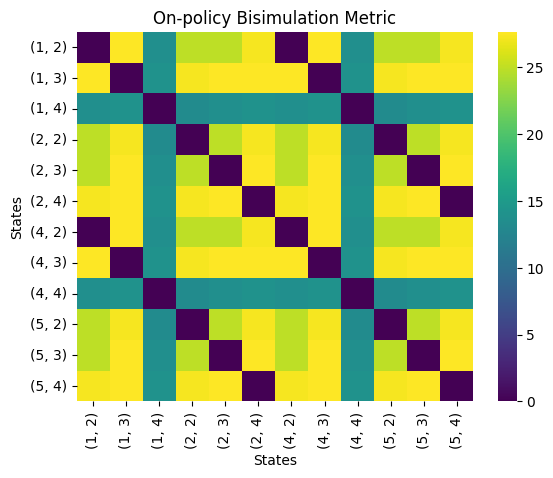

In [149]:
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards)
plot_distance_matrix(d, states)

In [ ]:
# # file_path = '../custom_envs/grid_envs/grid_world4.txt'
# file_path = 'final_project/custom_envs/grid_envs/grid_world.txt'

# grid = read_grid_world(file_path)
# print(grid)

# states, rewards, transitions = calculate_rewards_and_transitions(grid)

In [ ]:
# d = compute_bisimulation_metric(grid = grid,
#                                 states = states,
#                                 rewards = rewards)
# plot_distance_matrix(d, states)

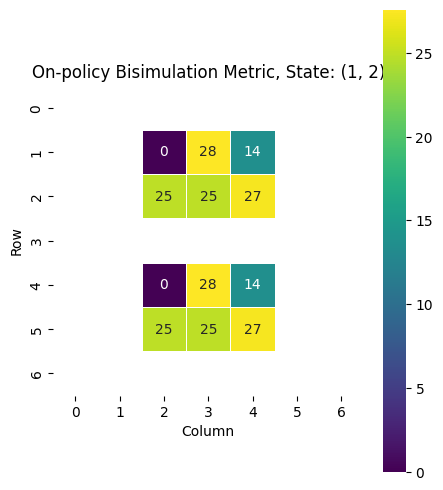

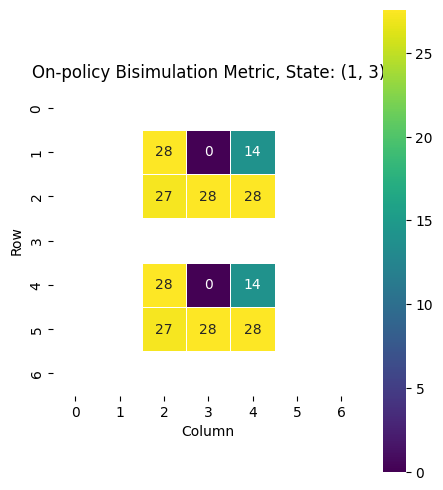

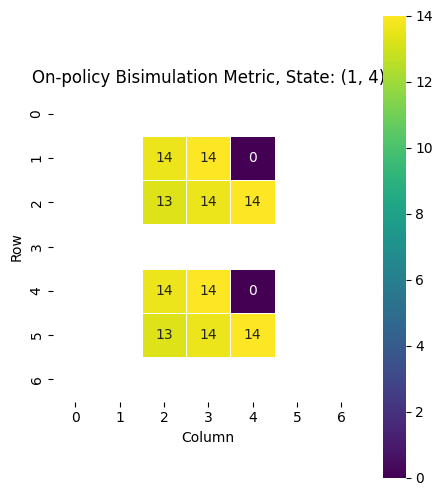

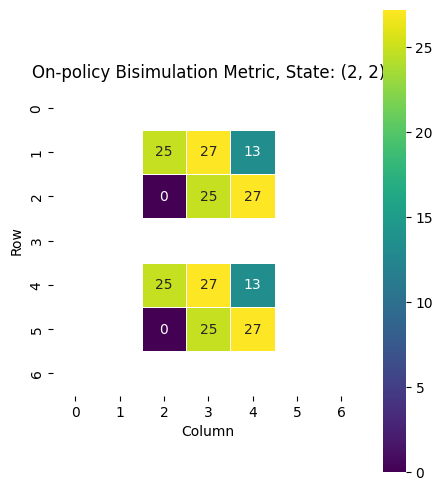

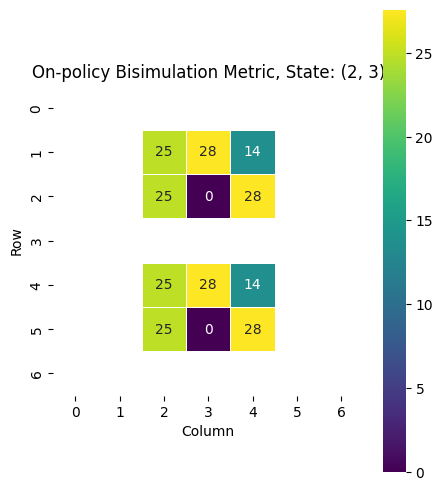

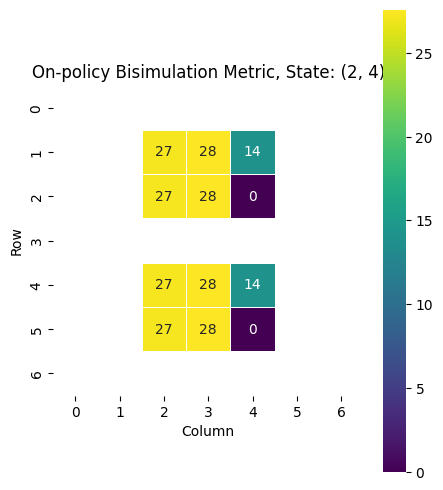

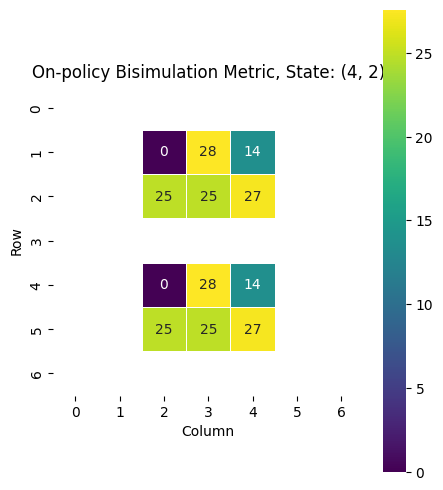

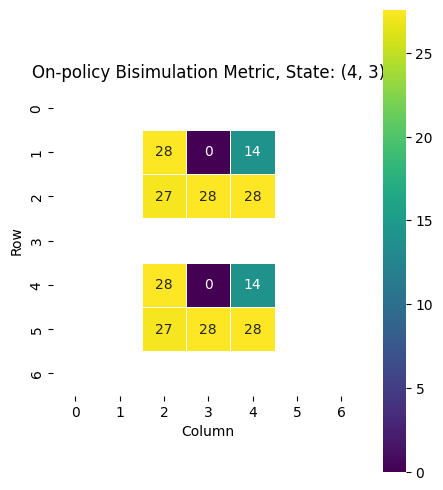

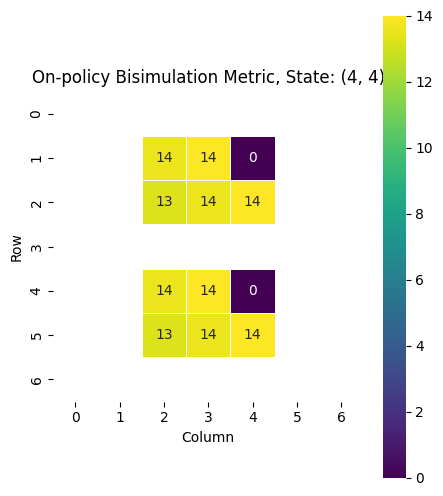

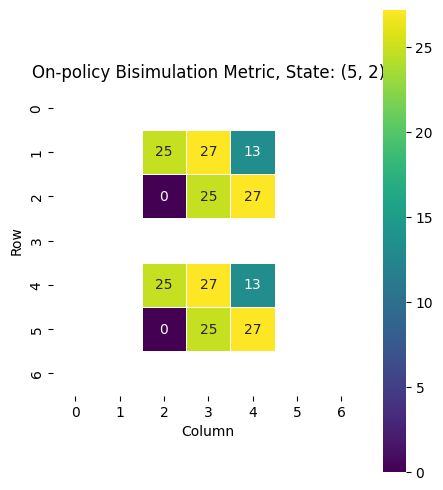

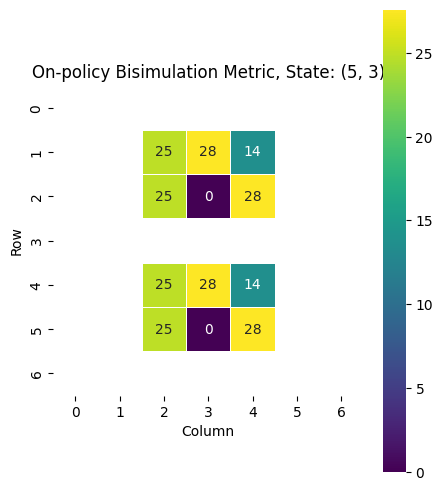

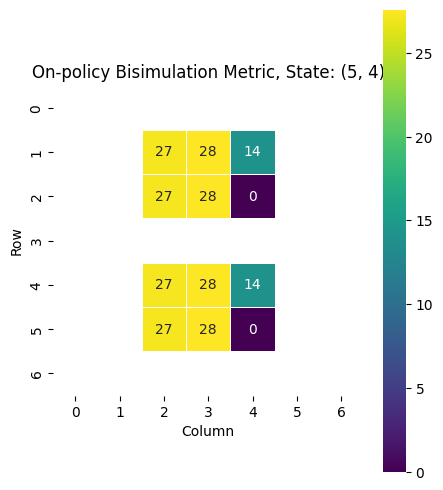

In [150]:
for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i])#, save=True, save_suffix="_grid_world")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


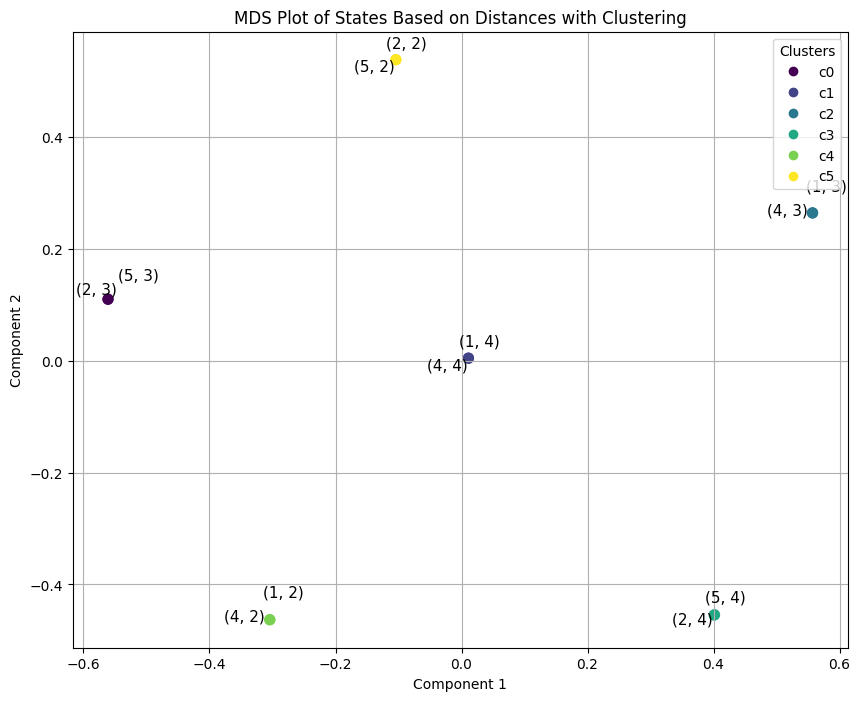

In [151]:
plot_distances(d, states, n_clusters=6)

## Testing grid_world 1

In [138]:
# file_path = '../custom_envs/grid_envs/grid_world1.txt'
file_path = 'final_project/custom_envs/grid_envs/grid_world1.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)
states

[['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' '.' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']]


[(1, 2),
 (1, 3),
 (1, 4),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 3),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 2),
 (5, 3),
 (5, 4)]

In [139]:
rewards

defaultdict(dict,
            {(1, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (1, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (1, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (2, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1},
             (3, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (4, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (4, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (4, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (5, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1}})

In [140]:
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards)
d.shape

(13, 13)

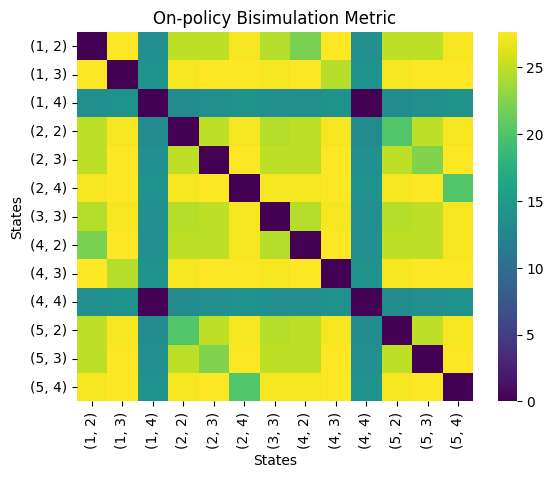

In [141]:
plot_distance_matrix(d, states)

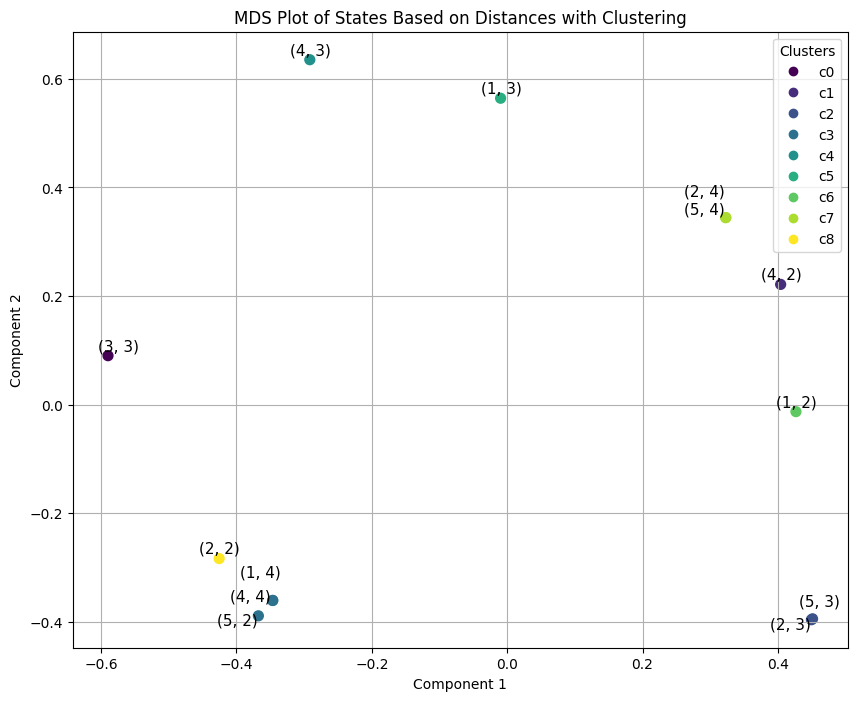

In [69]:
plot_distances(d, states, n_clusters=9)

## On-Policy Bisimulation metric


In [21]:
file_path = 'final_project/custom_envs/grid_envs/grid_world4.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)
states

[['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']]


[(1, 2),
 (1, 3),
 (1, 4),
 (2, 2),
 (2, 3),
 (2, 4),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 2),
 (5, 3),
 (5, 4)]

In [22]:
rewards

defaultdict(dict,
            {(1, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (1, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (1, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (2, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1},
             (4, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (4, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (4, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (5, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1}})

In [23]:
rewards

defaultdict(dict,
            {(1, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (1, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (1, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (2, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (2, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1},
             (4, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (4, 3): {'up': -1, 'down': -1, 'left': -1, 'right': 14},
             (4, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (5, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
             (5, 4): {'up': 14, 'down': -1, 'left': -1, 'right': -1}})

In [24]:
transitions

defaultdict(list,
            {(1, 2): [1, 1, 1, 1],
             (1, 3): [1, 1, 1, 1],
             (1, 4): [0, 0, 0, 0],
             (2, 2): [1, 1, 1, 1],
             (2, 3): [1, 1, 1, 1],
             (2, 4): [1, 1, 1, 1],
             (4, 2): [1, 1, 1, 1],
             (4, 3): [1, 1, 1, 1],
             (4, 4): [0, 0, 0, 0],
             (5, 2): [1, 1, 1, 1],
             (5, 3): [1, 1, 1, 1],
             (5, 4): [1, 1, 1, 1]})

[['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']]
Optimal Value Function:
{(1, 2): 11.6, (1, 3): 14.0, (1, 4): 0, (2, 2): 9.44, (2, 3): 11.6, (2, 4): 14.0, (4, 2): 11.6, (4, 3): 14.0, (4, 4): 0, (5, 2): 9.44, (5, 3): 11.6, (5, 4): 14.0}

Optimal Policy:
[['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' 'r' 'r' 'G' 'x' 'x']
 ['x' 'x' 'u' 'u' 'u' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' 'r' 'r' 'G' 'x' 'x']
 ['x' 'x' 'u' 'u' 'u' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x']]


In [ ]:
# Define the grid world environment
file_path = 'final_project/custom_envs/grid_envs/grid_world4.txt'
grid = read_grid_world(file_path)
print(grid)

# Run value iteration
V, policy = value_iteration(grid, states, rewards)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)

In [167]:
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards,
                                policy = policy)
d.shape

(12, 12)

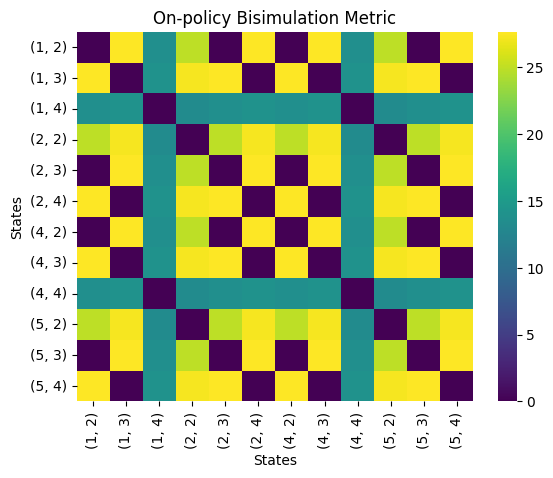

In [168]:
# Plot the heatmap of the distance matrix
import seaborn as sns
import matplotlib.pyplot as plt



plot_distance_matrix(d, states)

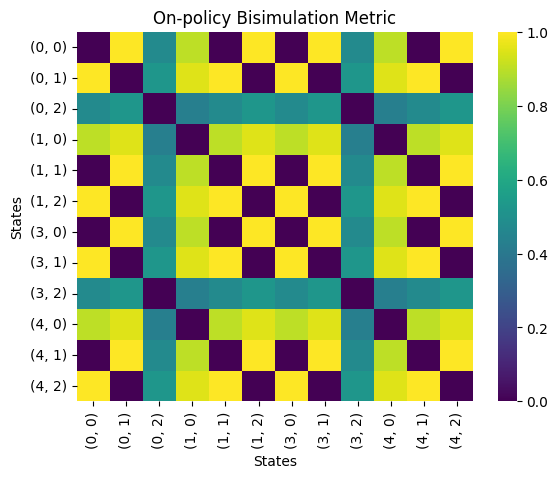

In [90]:
plot_distance_matrix(d / np.max(d), states)


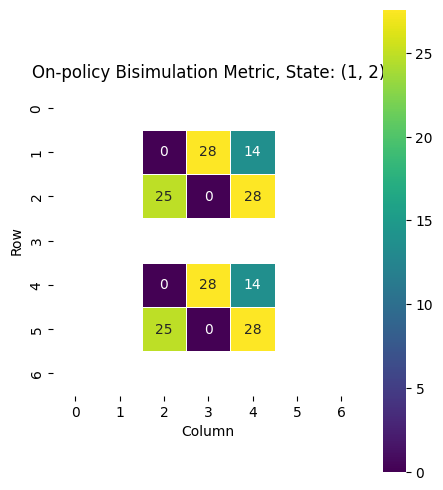

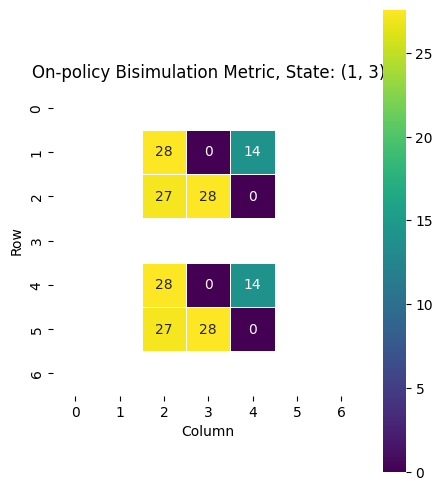

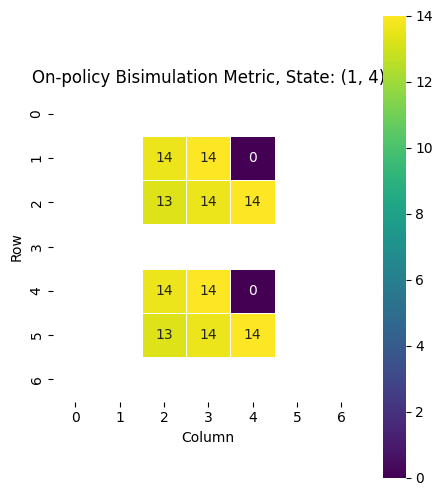

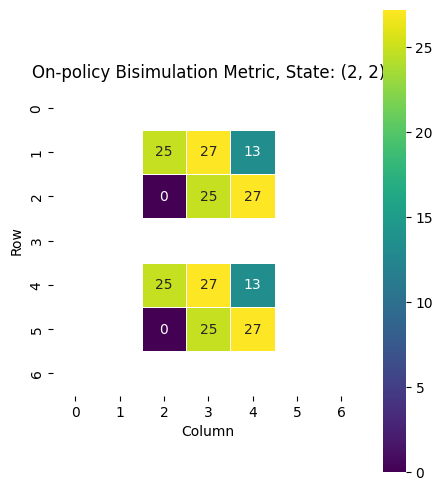

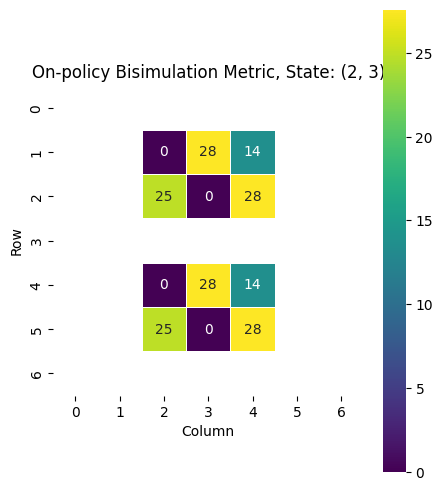

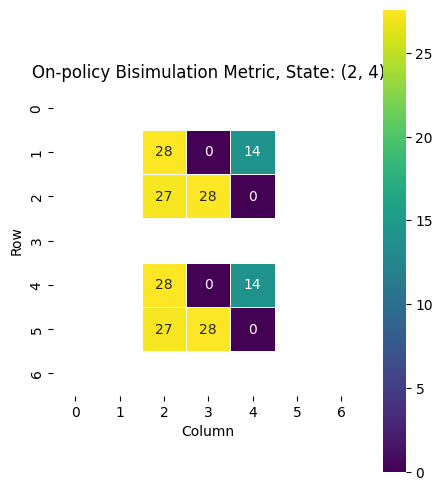

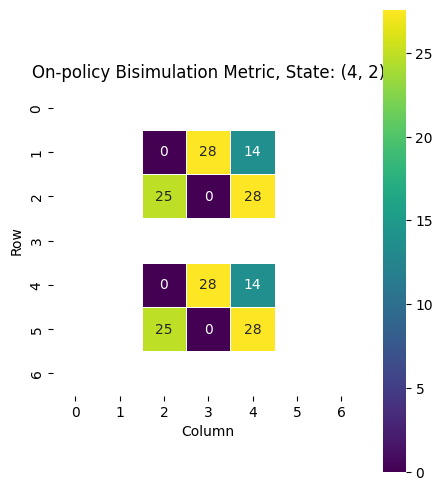

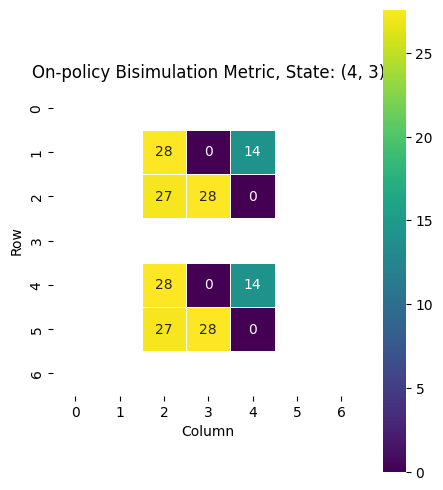

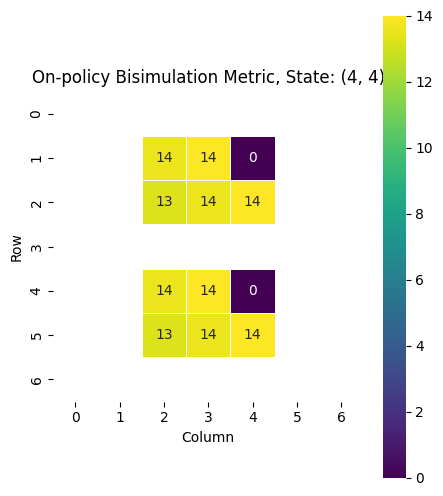

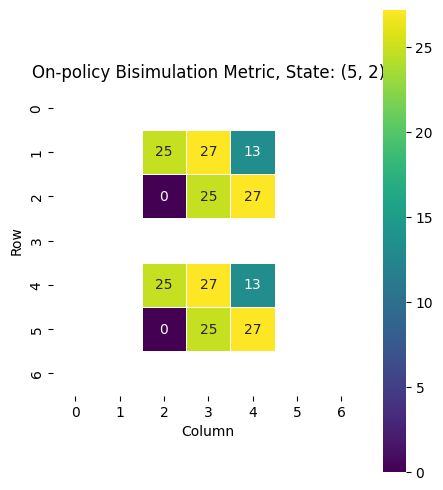

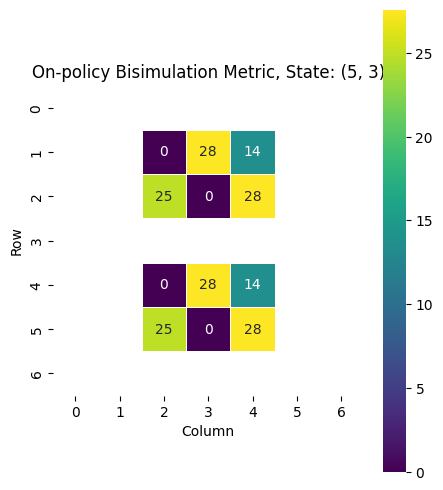

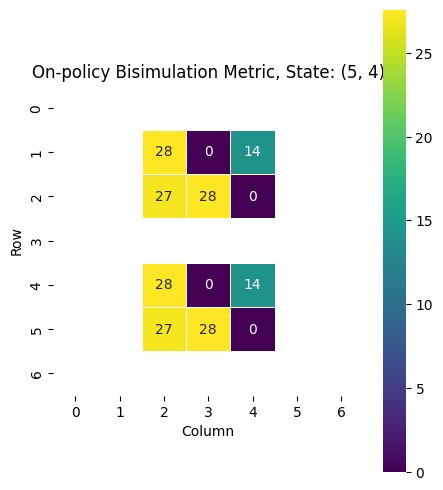

In [169]:

for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i])#, save=True, save_suffix="_grid_world")

## Testing grid_word1.txt with the passage

In [8]:
file_path = 'final_project/custom_envs/grid_envs/grid_world.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)

# Run value iteration
V, policy = value_iteration(grid, states, rewards)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' '.' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]
Optimal Value Function:
{(0, 0): 8.0, (0, 1): 10.0, (0, 2): 0, (1, 0): 6.2, (1, 1): 8.0, (1, 2): 10.0, (2, 1): 8.0, (3, 0): 8.0, (3, 1): 10.0, (3, 2): 0, (4, 0): 6.2, (4, 1): 8.0, (4, 2): 10.0}

Optimal Policy:
[['r' 'r' 'G']
 ['r' 'r' 'u']
 ['x' 'd' 'x']
 ['r' 'r' 'G']
 ['r' 'r' 'u']]


In [13]:
d, d_over_time = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards,
                                policy = policy,
                                get_iterations = True)
d

array([[ 0., 20., 10., 18.,  0., 20.,  0.,  0., 20., 10., 18.,  0., 20.],
       [20.,  0., 10., 20., 20.,  0., 20., 20.,  0., 10., 20., 20.,  0.],
       [10., 10.,  0., 10., 10., 10., 10., 10., 10.,  0., 10., 10., 10.],
       [18., 20., 10.,  0., 18., 20., 18., 18., 20., 10.,  0., 18., 20.],
       [ 0., 20., 10., 18.,  0., 20.,  0.,  0., 20., 10., 18.,  0., 20.],
       [20.,  0., 10., 20., 20.,  0., 20., 20.,  0., 10., 20., 20.,  0.],
       [ 0., 20., 10., 18.,  0., 20.,  0.,  0., 20., 10., 18.,  0., 20.],
       [ 0., 20., 10., 18.,  0., 20.,  0.,  0., 20., 10., 18.,  0., 20.],
       [20.,  0., 10., 20., 20.,  0., 20., 20.,  0., 10., 20., 20.,  0.],
       [10., 10.,  0., 10., 10., 10., 10., 10., 10.,  0., 10., 10., 10.],
       [18., 20., 10.,  0., 18., 20., 18., 18., 20., 10.,  0., 18., 20.],
       [ 0., 20., 10., 18.,  0., 20.,  0.,  0., 20., 10., 18.,  0., 20.],
       [20.,  0., 10., 20., 20.,  0., 20., 20.,  0., 10., 20., 20.,  0.]])

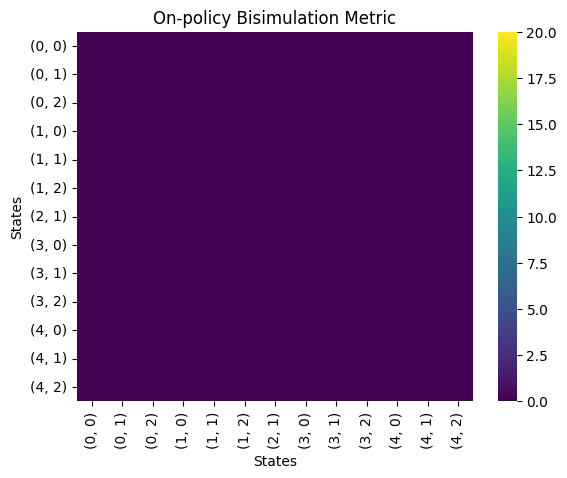

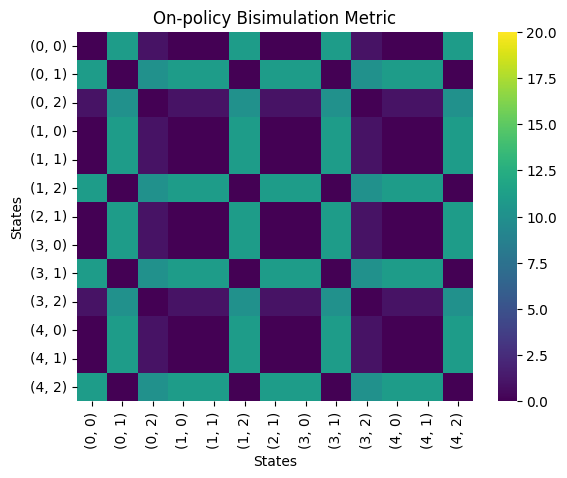

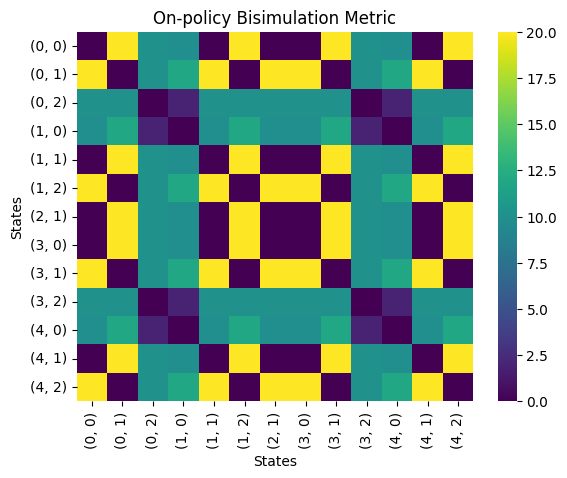

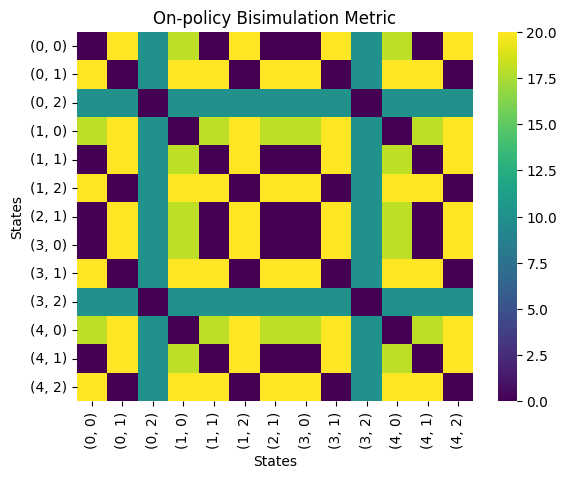

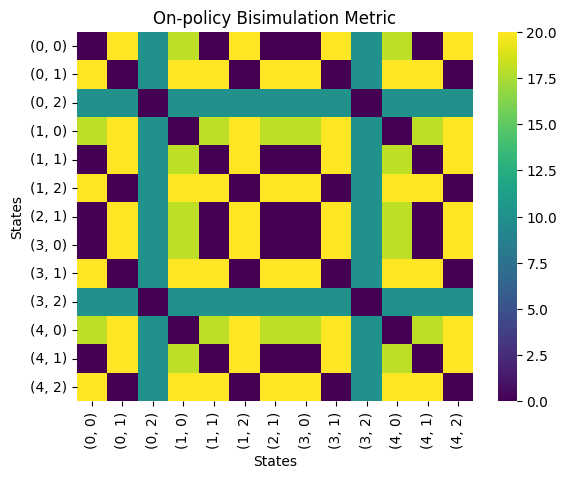

In [21]:
for i, distances in enumerate(d_over_time):
    plot_distance_matrix(distances, states, annot=False, heatmap_range = (0,20))

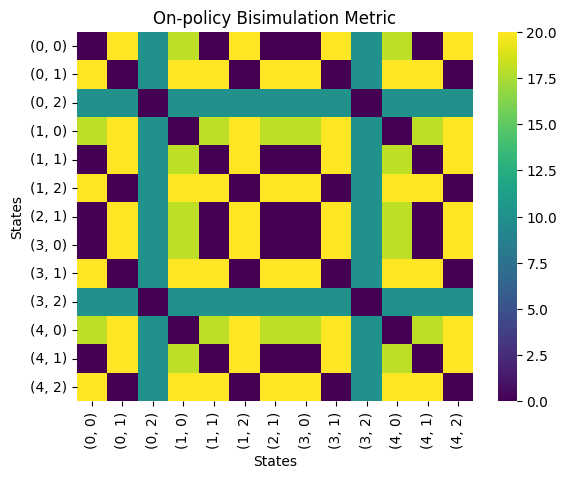

In [10]:
plot_distance_matrix(d, states, annot=False)

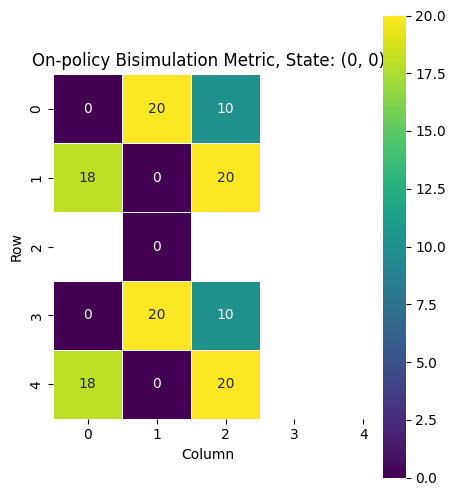

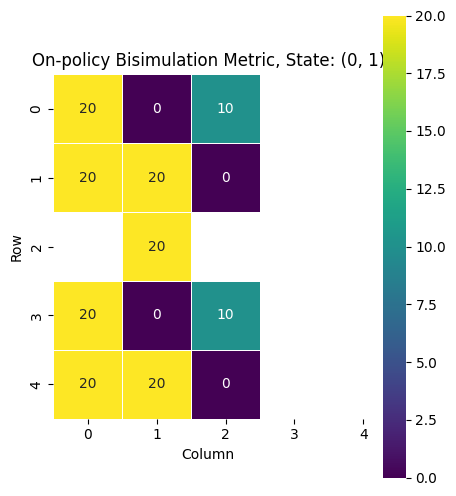

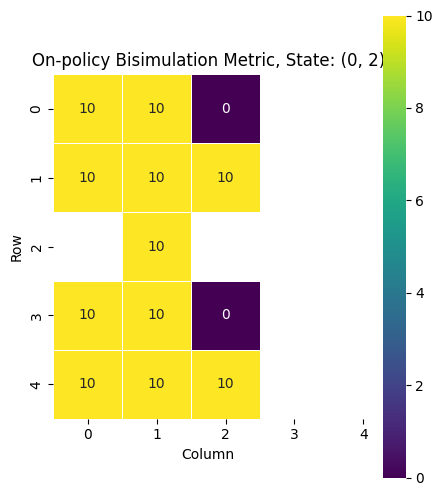

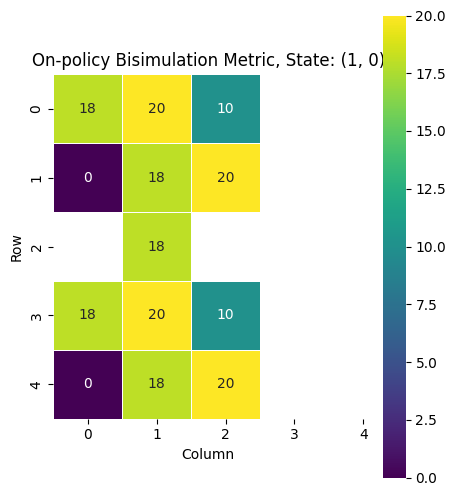

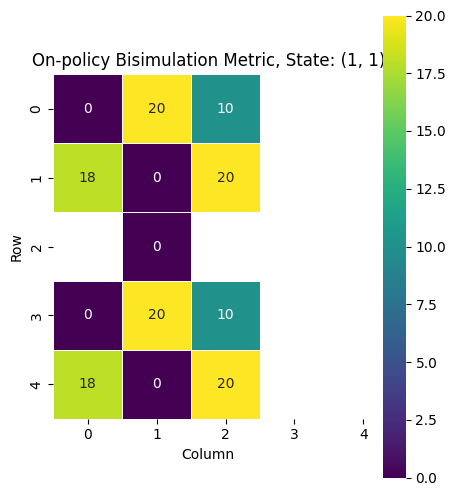

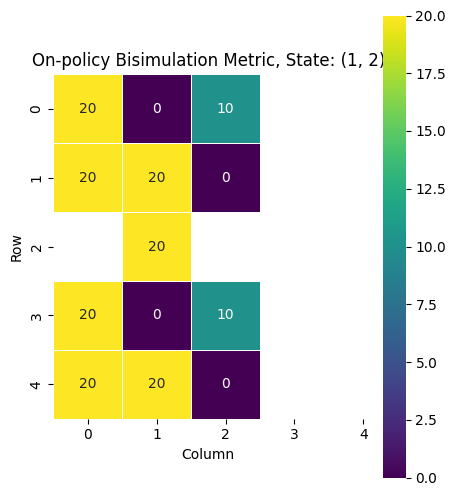

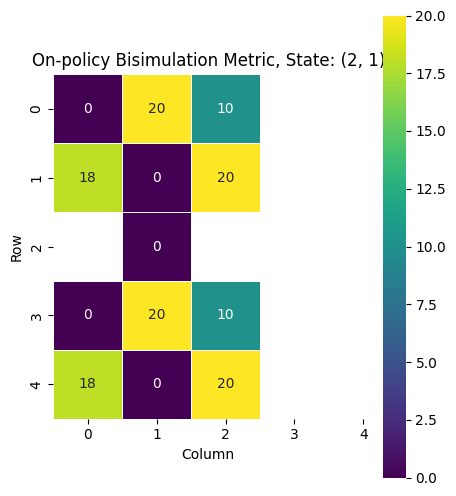

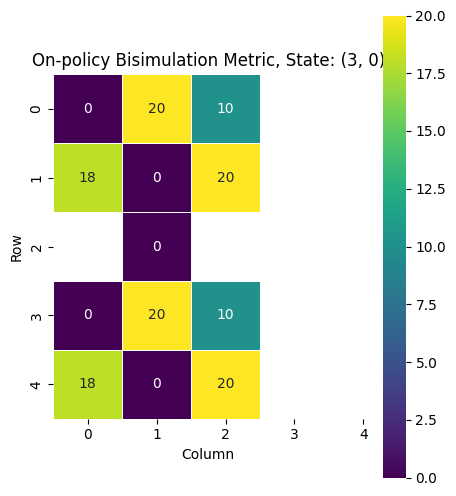

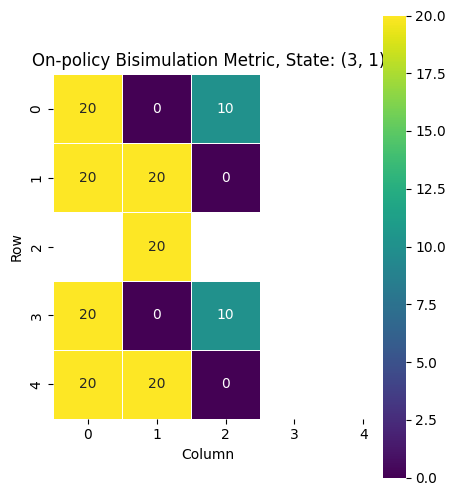

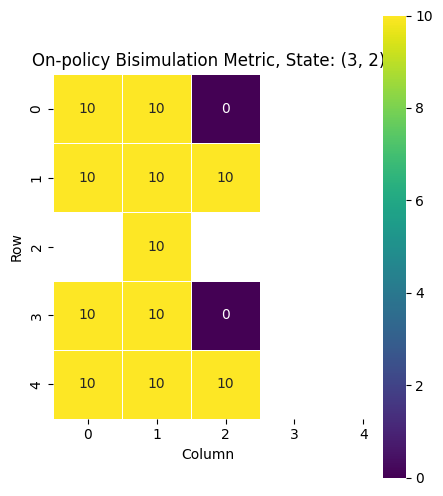

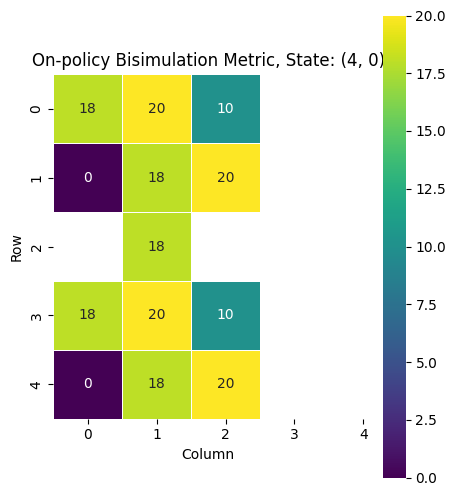

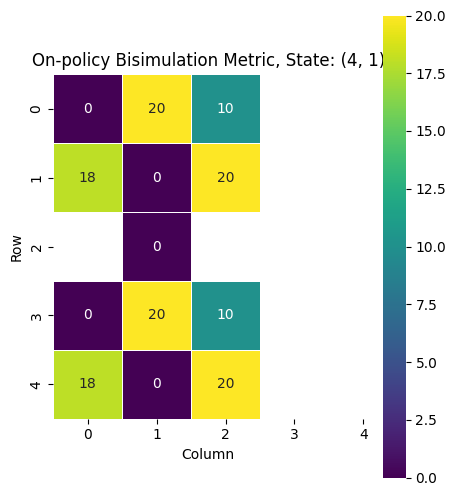

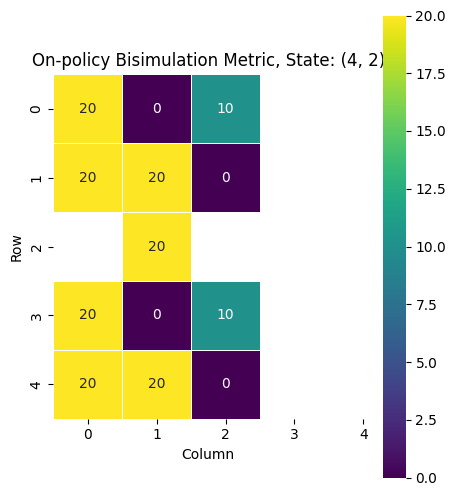

In [11]:
for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i], normalize=False) #, save=True, save_suffix="_grid_world1")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


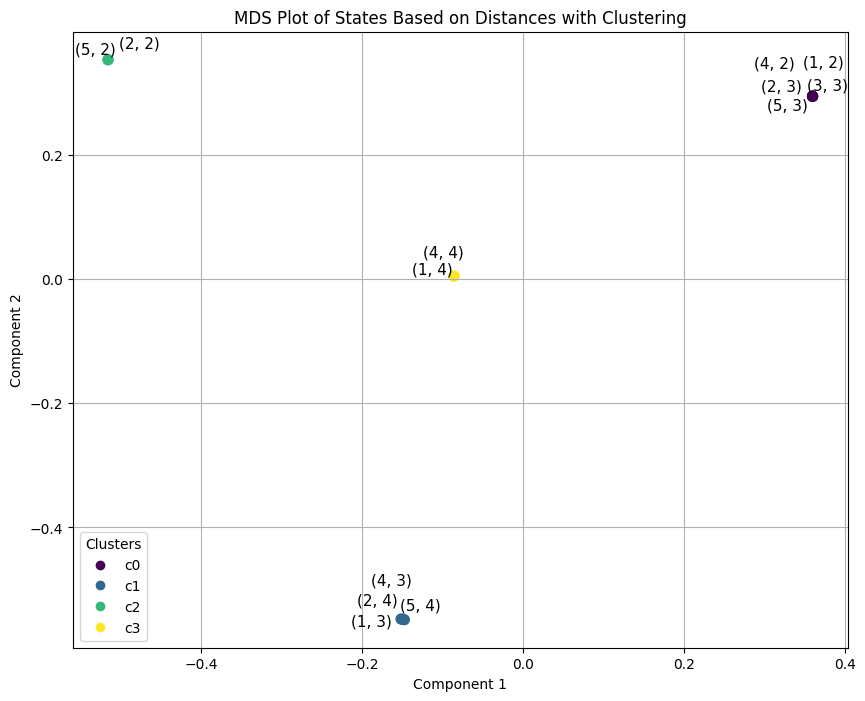

In [177]:
plot_distances(d, states)


# Testing grid_word2.txt

In [8]:
file_path = 'final_project/custom_envs/grid_envs/grid_world2.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)

# Run value iteration
V, policy = value_iteration(grid, states, rewards)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)

states = list(rewards.keys())
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards,
                                policy = policy)
d

[['x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' '.' '.' 'x' 'x']
 ['x' 'x' '.' '.' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' '.' 'x' 'x' 'x' 'x']
 ['x' 'x' '.' '.' '.' '.' 'G' 'x' 'x']
 ['x' 'x' '.' '.' '.' '.' '.' 'x' 'x']
 ['x' 'x' '.' '.' '.' '.' '.' 'x' 'x']
 ['x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x']]
Optimal Value Function:
{(1, 2): 10.412, (1, 3): 12.68, (1, 4): 15.2, (1, 5): 18.0, (1, 6): 0, (2, 2): 8.370800000000001, (2, 3): 10.412, (2, 4): 12.68, (2, 5): 15.2, (2, 6): 18.0, (3, 2): 6.533720000000001, (3, 3): 8.370800000000001, (3, 4): 10.412, (3, 5): 12.68, (3, 6): 15.2, (4, 4): 12.68, (5, 2): 10.412, (5, 3): 12.68, (5, 4): 15.2, (5, 5): 18.0, (5, 6): 0, (6, 2): 8.370800000000001, (6, 3): 10.412, (6, 4): 12.68, (6, 5): 15.2, (6, 6): 18.0, (7, 2): 6.533720000000001, (7, 3): 8.370800000000001, (7, 4): 10.412, (7, 5): 12.68, (7, 6): 15.2}

Optimal Policy:
[['x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x']
 ['x' 'x' 'r' 'r' 'r' 'r' 'G' 'x' 'x']
 ['

array([[ 0.     , 28.512  , 31.032  , 33.832  , 15.832  , 25.6608 ,
         0.     , 28.512  , 31.032  , 33.832  , 25.13592, 25.6608 ,
         0.     , 28.512  , 31.032  , 28.512  ,  0.     , 28.512  ,
        31.032  , 33.832  , 15.832  , 25.6608 ,  0.     , 28.512  ,
        31.032  , 33.832  , 25.13592, 25.6608 ,  0.     , 28.512  ,
        31.032  ],
       [28.512  ,  0.     , 31.68   , 34.48   , 16.48   , 27.9288 ,
        28.512  ,  0.     , 31.68   , 34.48   , 27.40392, 27.9288 ,
        28.512  ,  0.     , 31.68   ,  0.     , 28.512  ,  0.     ,
        31.68   , 34.48   , 16.48   , 27.9288 , 28.512  ,  0.     ,
        31.68   , 34.48   , 27.40392, 27.9288 , 28.512  ,  0.     ,
        31.68   ],
       [31.032  , 31.68   ,  0.     , 35.2    , 17.2    , 30.4488 ,
        31.032  , 31.68   ,  0.     , 35.2    , 29.92392, 30.4488 ,
        31.032  , 31.68   ,  0.     , 31.68   , 31.032  , 31.68   ,
         0.     , 35.2    , 17.2    , 30.4488 , 31.032  , 31.68   ,
         0

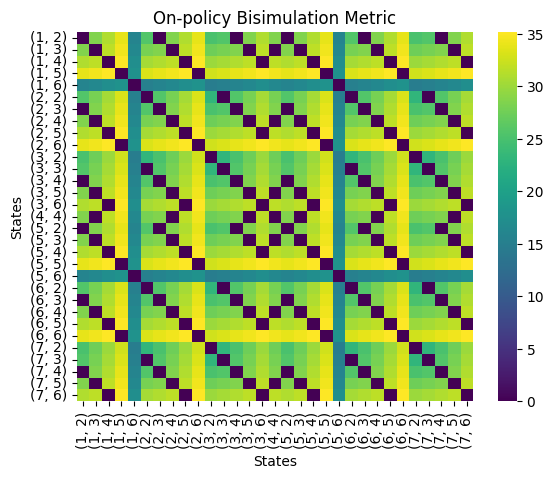

In [9]:
plot_distance_matrix(d, states)

In [10]:
file_path = 'final_project/custom_envs/grid_envs/distances_grid_world2.txt'
save_distances(d, grid, states, filename = file_path)

Saving {'(1, 2)': [25.6608, 28.512, 0.0, 0.0], '(1, 3)': [28.512, 31.68, 0.0, 28.512], '(1, 4)': [31.68, 35.2, 0.0, 31.68], '(1, 5)': [35.2, 18.0, 0.0, 35.2], '(1, 6)': [0.0, 0.0, 0.0, 0.0], '(2, 2)': [23.0947, 25.6608, 25.6608, 0.0], '(2, 3)': [25.6608, 28.512, 28.512, 25.6608], '(2, 4)': [28.512, 31.68, 31.68, 28.512], '(2, 5)': [31.68, 35.2, 35.2, 31.68], '(2, 6)': [35.2, 0.0, 18.0, 35.2], '(3, 2)': [0.0, 23.0947, 23.0947, 0.0], '(3, 3)': [0.0, 25.6608, 25.6608, 23.0947], '(3, 4)': [28.512, 28.512, 28.512, 25.6608], '(3, 5)': [0.0, 31.68, 31.68, 28.512], '(3, 6)': [0.0, 0.0, 35.2, 31.68], '(4, 4)': [31.68, 0.0, 28.512, 0.0], '(5, 2)': [25.6608, 28.512, 0.0, 0.0], '(5, 3)': [28.512, 31.68, 0.0, 28.512], '(5, 4)': [31.68, 35.2, 31.68, 31.68], '(5, 5)': [35.2, 18.0, 0.0, 35.2], '(5, 6)': [0.0, 0.0, 0.0, 0.0], '(6, 2)': [23.0947, 25.6608, 25.6608, 0.0], '(6, 3)': [25.6608, 28.512, 28.512, 25.6608], '(6, 4)': [28.512, 31.68, 31.68, 28.512], '(6, 5)': [31.68, 35.2, 35.2, 31.68], '(6, 6)':

In [64]:
import json

# Load JSON file
with open(file_path, 'r') as json_file:
    data = json.load(json_file)


In [70]:
state = np.random.randint(0, 8, size=2, dtype=int)
data[str(tuple(state))]

[0.0, 0.0, 35.2, 31.68]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


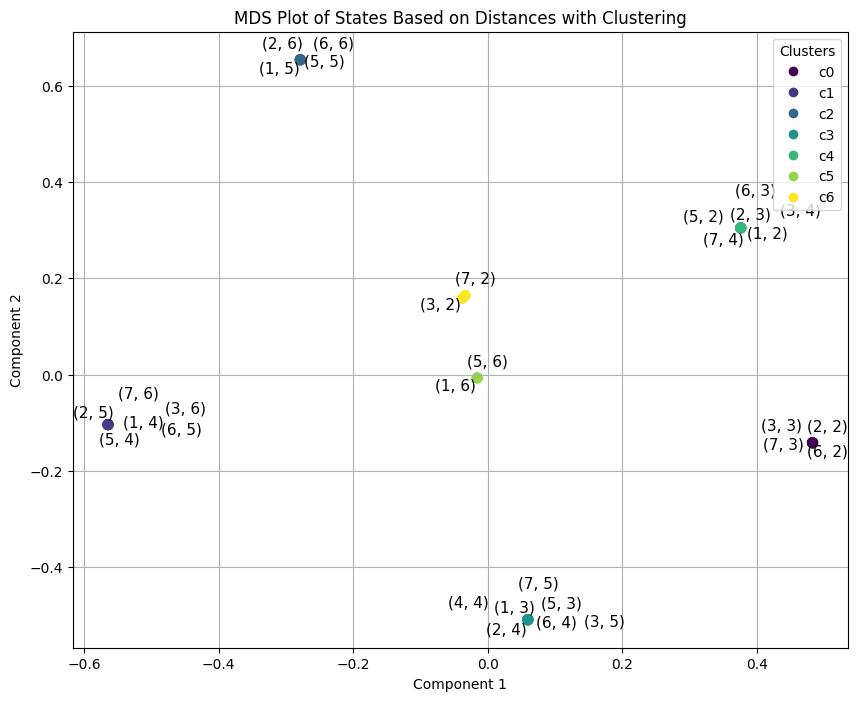

In [196]:
plot_distances(d, states, n_clusters=7)

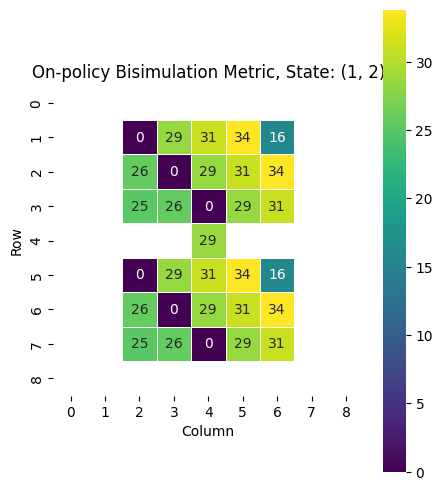

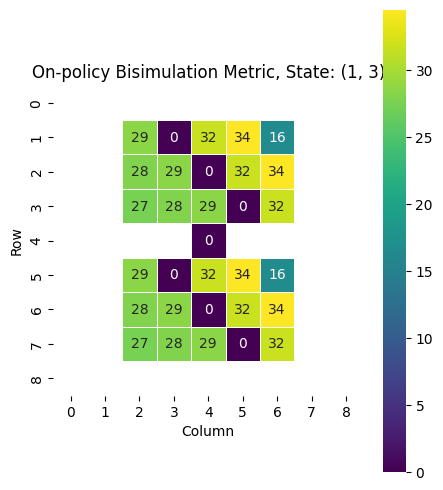

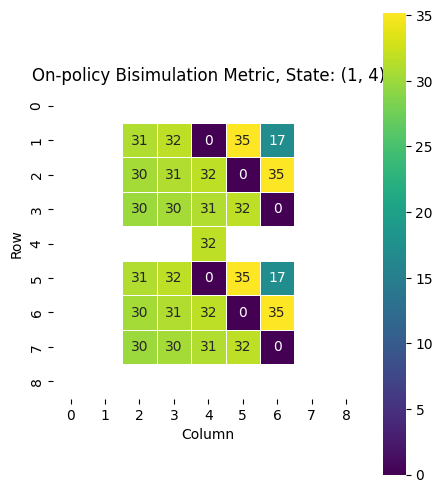

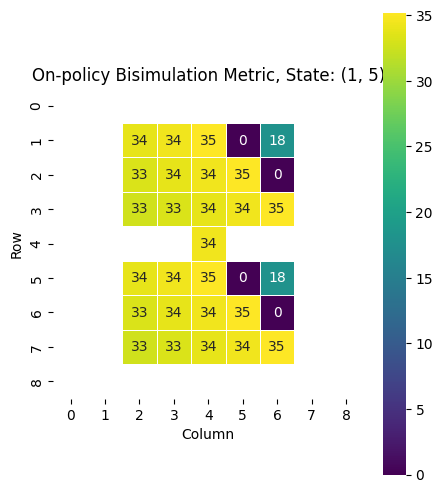

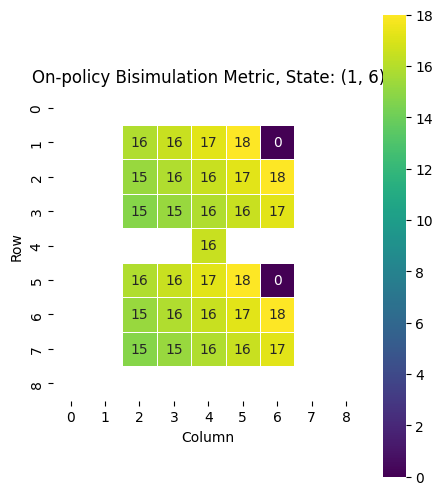

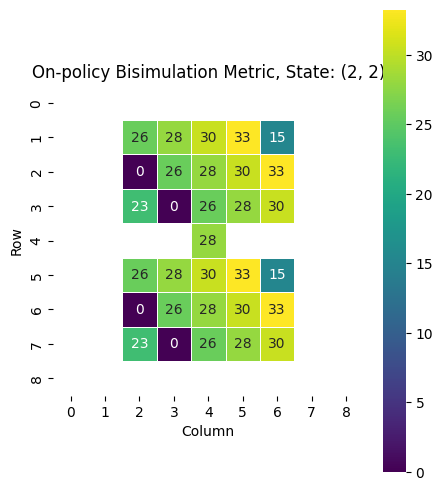

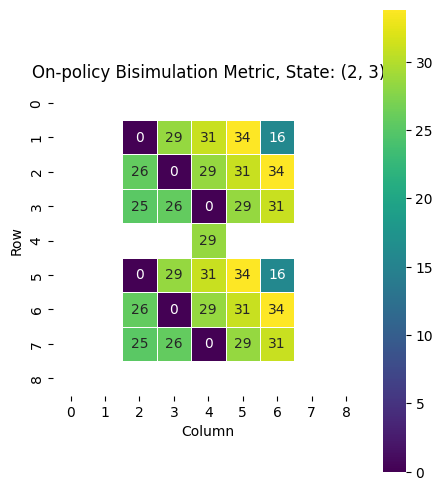

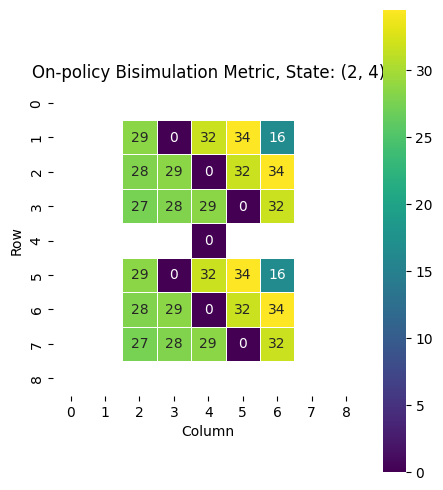

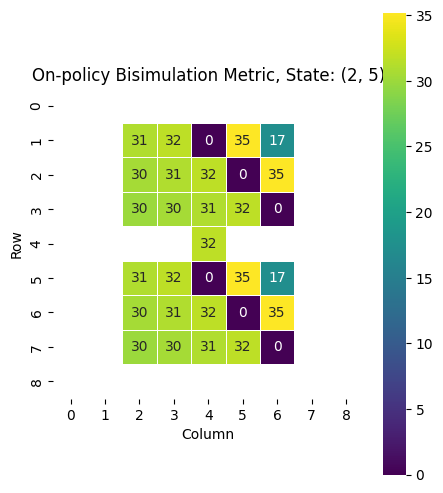

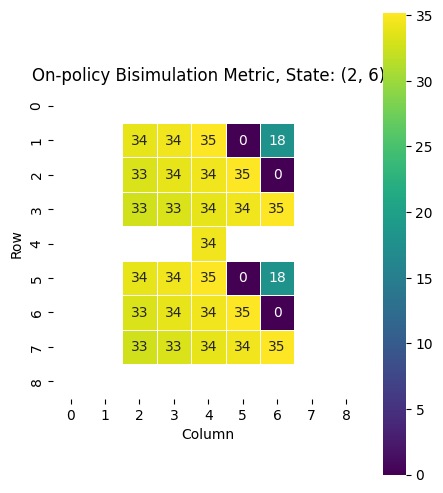

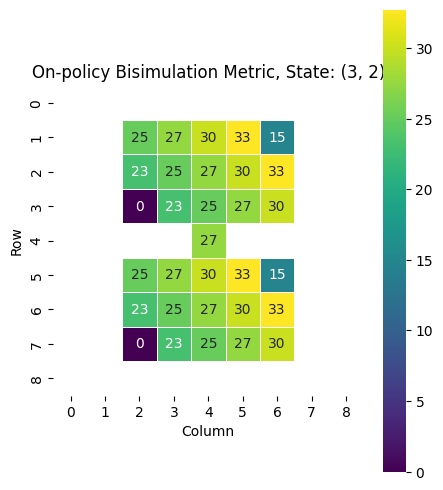

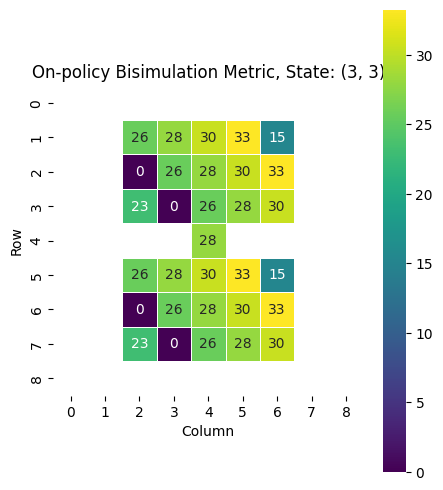

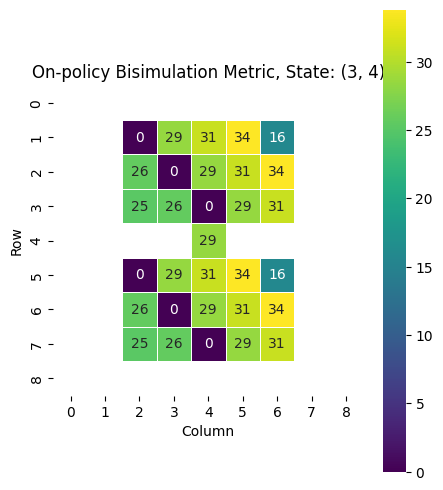

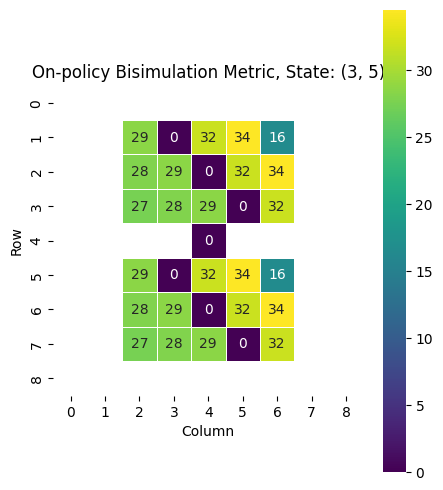

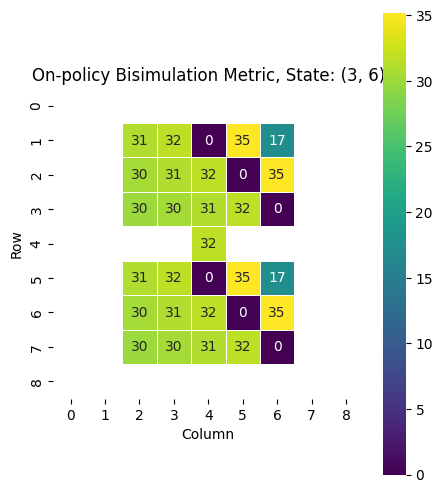

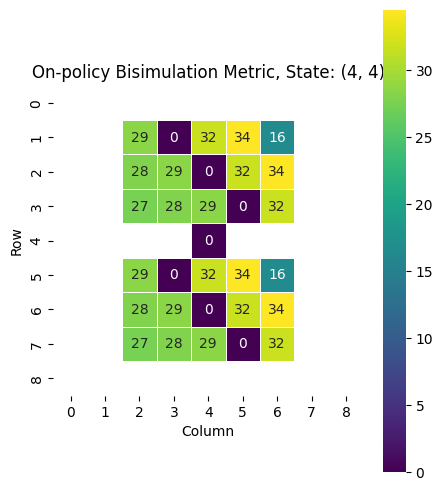

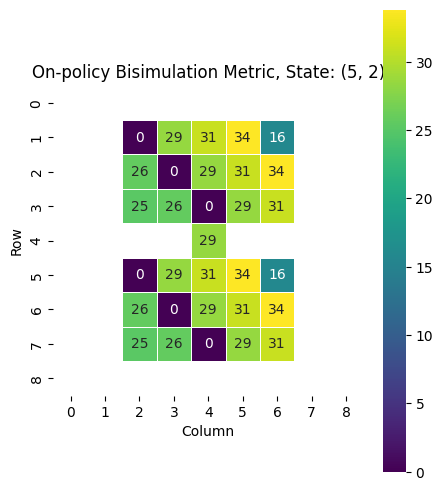

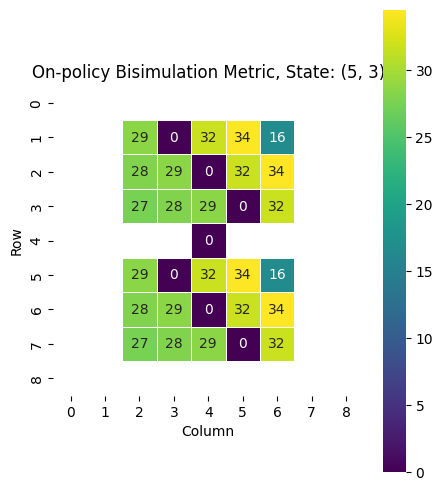

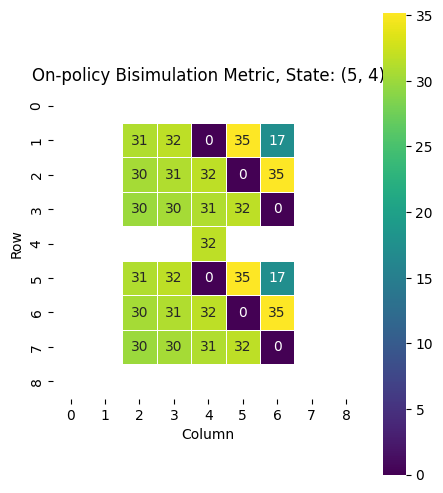

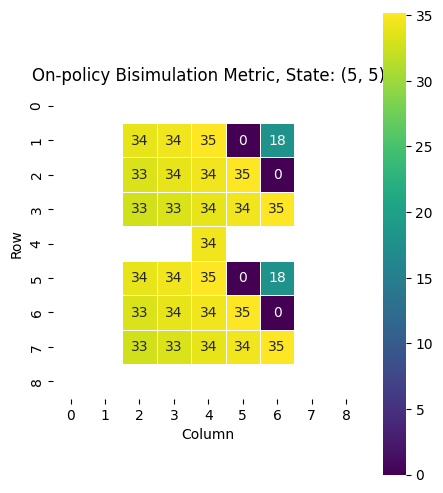

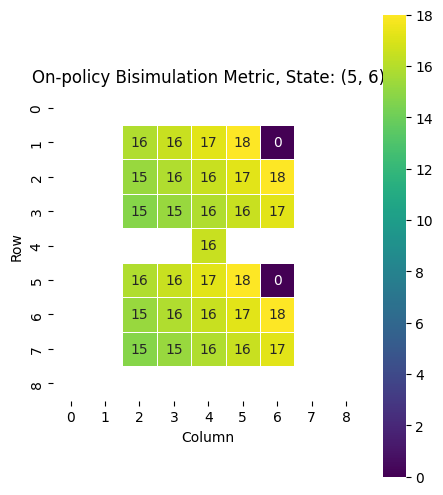

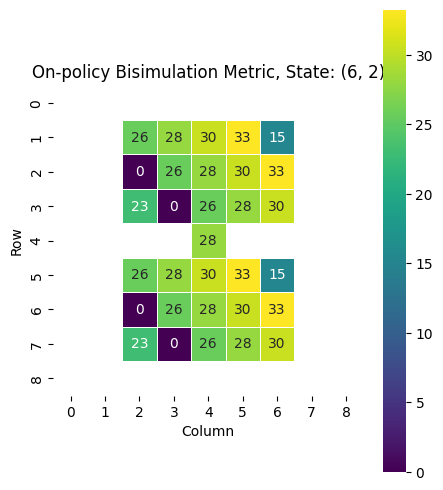

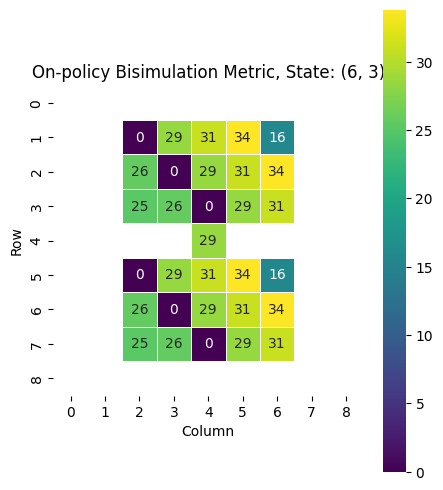

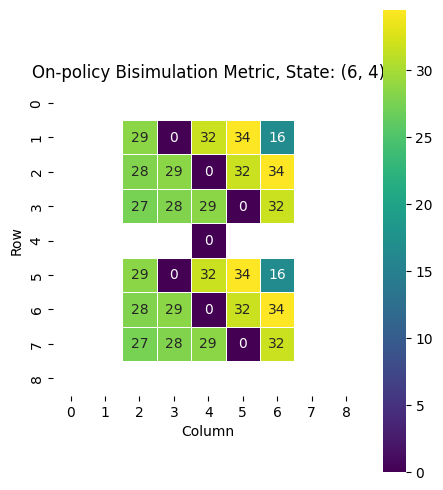

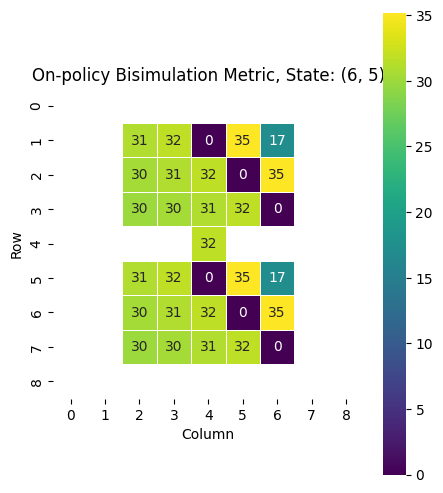

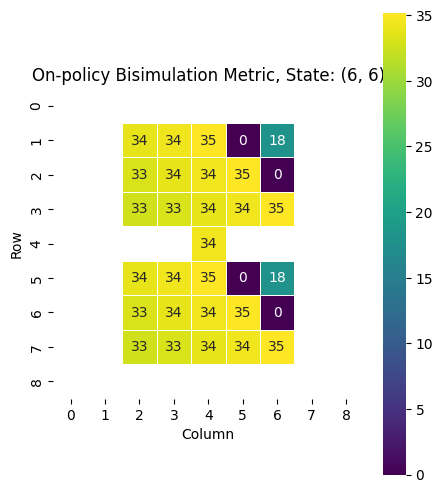

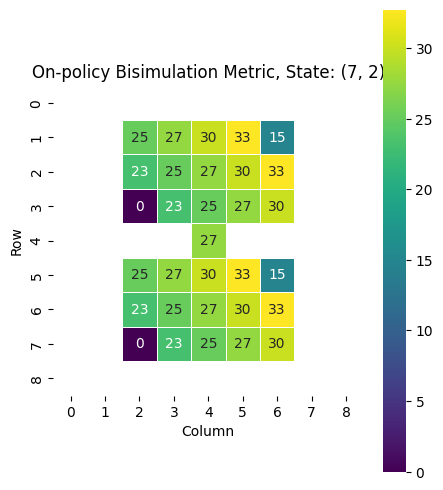

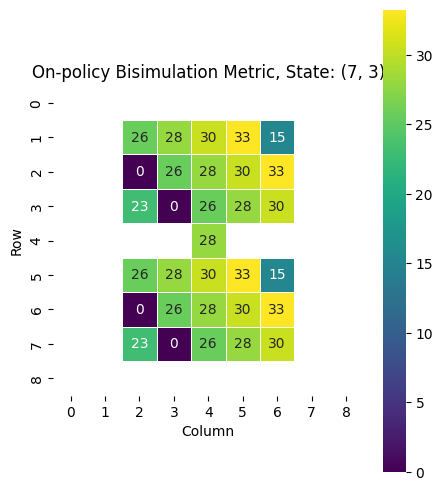

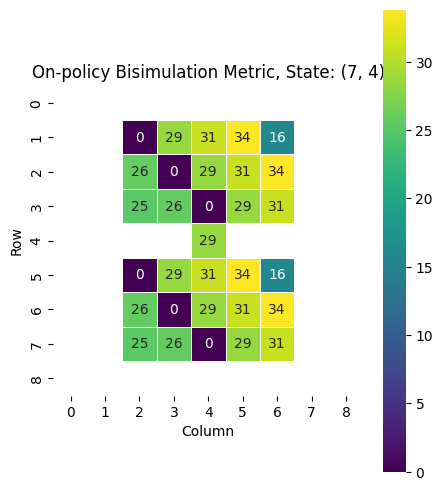

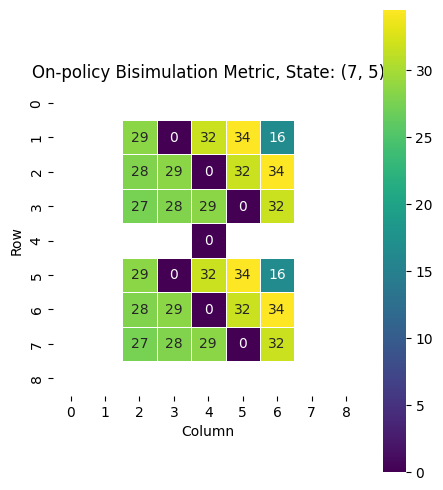

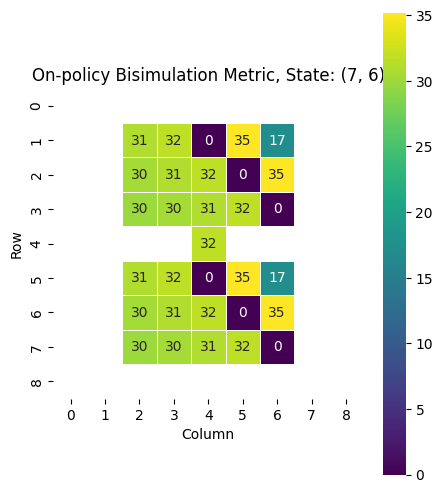

In [183]:
for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i]) #, save=True, save_suffix="_grid_world2")